## **Libraries and Dependencies**

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomFlip, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import cv2
import logging
import warnings
import json


# Suppress warnings from the logging module
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)


## **Tensorflow Version**

In [2]:
# Tensorflow Version
print(tf.__version__)

2.10.0


## **GPU Checker**

In [3]:
# Check if any GPU devices are detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
else:
    print("No GPU detected.")

GPUs detected: 1


## **Tensorflow Warning Suppression**

In [4]:
# Suppress TensorFlow logging except for fatal errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## **Global Variables**

In [5]:
# Set seed
SEED = 338424

# Global variables
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_classes = 18 # Number of folders in dataset
AUTOTUNE = tf.data.AUTOTUNE

## **Dataset: Loading, Splitting, Shuffling, Caching**

In [6]:
# Load Dataset
dataset_dir = 'dataset/hagridset'
full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    seed=SEED,
    image_size=(IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Total length of the dataset
total_size = len(full_ds)

# Compute indices for the splits
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - (train_size + val_size)

# Split the dataset and shuffle
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED)
test_ds = full_ds.skip(train_size + val_size).shuffle(test_size, seed=SEED)

# Cache the dataset in memory (or use a directory to store it on disk if necessary)
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = full_ds.skip(train_size + val_size).cache().prefetch(buffer_size=AUTOTUNE)

# Count samples in each subset
def count_samples(dataset):
    sample_count = sum(1 for _ in dataset.unbatch())
    return sample_count

# Output the number of samples for each dataset
print(f'Using {count_samples(train_ds)} samples in the Training set')
print(f'Using {count_samples(val_ds)} samples in the Validation set')
print(f'Using {count_samples(test_ds)} samples in the Test set')

Found 125912 files belonging to 18 classes.
Using 88128 samples in the Training set
Using 25184 samples in the Validation set
Using 12600 samples in the Test set


In [7]:
# Get class names
class_names = full_ds.class_names
class_names

['call',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

## **Regularization Factors**

This code snippet defines the values for L1 and L2 regularization, which are both set to 0.01. It then creates an "Elastic Net Regularizer" that combines these L1 and L2 values to help prevent the model from overfitting by penalizing overly complex or large weight values in the model's learning process.

In [8]:
# Define L1 and L2 regularization factors
l1_factor = 0.01  # Example value
l2_factor = 0.01  # Example value

# Elastic Net Regularizer
elastic_net_regularizer = regularizers.l1_l2(l1=l1_factor, l2=l2_factor)

## **Callbacks: Learning Rate Scheduler and Early Stopping**

In [9]:
# Define a learning rate schedule
def lr_time_based_decay(epoch, lr):
    # This function adjusts the learning rate over each epoch based on the initial learning rate,
    # applying a decay factor that increases with the epoch number. It effectively reduces the 
    # learning rate over time, which can help in calibrating the model adjustments as it 
    # approaches a minimum in the loss surface.
    return lr * 1 / (1 + 0.01 * epoch)

# Define callbacks
callbacks = [
    # EarlyStopping prevents overfitting by stopping training when the validation loss 
    # has not improved for 3 consecutive epochs ('patience=3'). It also restores the 
    # weights of the model to those of the epoch with the best validation loss, ensuring 
    # the model retains the best learned features even if it starts to overfit afterward.
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    # LearningRateScheduler adjusts the learning rate according to the lr_time_based_decay function above.
    # It logs the new learning rate at the start of each epoch ('verbose=1'), helping to control
    # the step size of model updates, which can be crucial for reaching convergence efficiently.
    LearningRateScheduler(lr_time_based_decay, verbose=1)
]

## **Data Augmentation**

In [10]:
# Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

---

# **Convolutional Neural Networks (CNN): Deep Models**

---

## **CNN Model: Deep**

In [11]:
# Define the CNN Model from Scratch
def build_scratch_cnn_deep():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with an initial learning rate
    model.compile(
        # Adam optimizer is used with a specified initial learning rate of 0.001. The learning rate
        # controls how much the weights of the model are adjusted relative to the gradient of the loss 
        # function. A higher learning rate might converge quickly, but too high can cause the training 
        # to diverge. A lower learning rate ensures more reliable convergence but at the risk of slowing
        # down the training process. The chosen rate of 0.001 is a starting point that balances these factors.
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

# Instantiate and summarize the lighter model
scratch_model_deep = build_scratch_cnn_deep()
scratch_model_deep.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)       

### **CNN Model: Deep Training**

In [12]:
# Train CNN Model
history_deep = scratch_model_deep.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 36s 12ms/step - loss: 1.7865 - accuracy: 0.4529 - val_loss: 1.0698 - val_accuracy: 0.6572 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 32s 11ms/step - loss: 0.8583 - accuracy: 0.7253 - val_loss: 0.6559 - val_accuracy: 0.7915 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 31s 11ms/step - loss: 0.6545 - accuracy: 0.7885 - val_loss: 0.5658 - val_accuracy: 0.8172 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 31s 11ms/step - loss: 0.5396 - accuracy: 0.8242 - val_loss: 0.5175 - val_accuracy: 0.8349 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler 

#### **CNN Model: Deep Save**

In [13]:
# Save Model: .json
# Saves the Model Architecture
for key in history_deep.history.keys():
    history_deep.history[key] = [float(i) for i in history_deep.history[key]]

# Write the JSON file
with open('json/cnn_model_deep.json', 'w') as f:
    json.dump(history_deep.history, f)


# Save Model: .h5
# Saves the Model Weights and Configurations
scratch_model_deep.save('h5/scratch_model_deep.h5')

## **CNN Model: Shallow Calibrated**

In [14]:
# Define the CNN Model from Scratch
def build_scratch_cnn_deep_calibrated():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with an initial learning rate
    model.compile(
        # Adam optimizer is used with a specified initial learning rate of 0.001. The learning rate
        # controls how much the weights of the model are adjusted relative to the gradient of the loss 
        # function. A higher learning rate might converge quickly, but too high can cause the training 
        # to diverge. A lower learning rate ensures more reliable convergence but at the risk of slowing
        # down the training process. The chosen rate of 0.001 is a starting point that balances these factors.
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

# Instantiate and summarize the lighter model
scratch_model_deep_calibrated = build_scratch_cnn_deep_calibrated()
scratch_model_deep_calibrated.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)       

### **CNN Model: Deep Calibrated - Training**

In [15]:
# Train CNN Model
history_deep_calibrated = scratch_model_deep_calibrated.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 35s 12ms/step - loss: 2.1597 - accuracy: 0.2965 - val_loss: 1.3207 - val_accuracy: 0.5808 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 35s 13ms/step - loss: 1.1556 - accuracy: 0.6290 - val_loss: 0.7653 - val_accuracy: 0.7559 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 33s 12ms/step - loss: 0.8540 - accuracy: 0.7295 - val_loss: 0.6372 - val_accuracy: 0.7953 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 33s 12ms/step - loss: 0.6997 - accuracy: 0.7778 - val_loss: 0.7292 - val_accuracy: 0.7661 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler 

#### **CNN Model: Deep Calibrated - Save**

In [18]:
# Save Model: .json
# Saves the Model Architecture
for key in history_deep_calibrated.history.keys():
    history_deep_calibrated.history[key] = [float(i) for i in history_deep_calibrated.history[key]]

# Write the JSON file
with open('json/cnn_model_deep_calibrated.json', 'w') as f:
    json.dump(history_deep_calibrated.history, f)


# Save Model: .h5
# Saves the Model Weights and Configurations
scratch_model_deep_calibrated.save('h5/scratch_model_deep_calibrated.h5')

## **CNN Model: Deep Calibrated Data Augmentation**

In [20]:
# Define the CNN Model from Scratch
def build_scratch_cnn_deep_calibrated_da():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(data_augmentation_layers)
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(512, activation='relu', kernel_regularizer=elastic_net_regularizer))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with an initial learning rate
    model.compile(
        # Adam optimizer is used with a specified initial learning rate of 0.001. The learning rate
        # controls how much the weights of the model are adjusted relative to the gradient of the loss 
        # function. A higher learning rate might converge quickly, but too high can cause the training 
        # to diverge. A lower learning rate ensures more reliable convergence but at the risk of slowing
        # down the training process. The chosen rate of 0.001 is a starting point that balances these factors.
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    return model

# Instantiate and summarize the lighter model
scratch_model_deep_calibrated_da = build_scratch_cnn_deep_calibrated_da()
scratch_model_deep_calibrated_da.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 batch_normalization_18 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 32, 32, 16)       

### **CNN Model: Deep Calibrated Data Augmentation - Training**

In [21]:
# Train CNN Model
history_deep_calibrated_da = scratch_model_deep_calibrated_da.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 329s 119ms/step - loss: 4.7639 - accuracy: 0.1884 - val_loss: 2.4763 - val_accuracy: 0.4022 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 317s 115ms/step - loss: 2.2280 - accuracy: 0.4962 - val_loss: 1.7835 - val_accuracy: 0.6508 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 338s 123ms/step - loss: 1.7780 - accuracy: 0.6415 - val_loss: 1.4739 - val_accuracy: 0.7299 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 321s 117ms/step - loss: 1.5761 - accuracy: 0.6938 - val_loss: 1.3302 - val_accuracy: 0.7738 - lr: 9.4241e-04

Epoch 5: LearningRateSc

#### **CNN Model: Deep Calibrated Data Augmentation**

In [23]:
# Save Model: .json
# Saves the Model Architecture
for key in history_deep_calibrated_da.history.keys():
    history_deep_calibrated_da.history[key] = [float(i) for i in history_deep_calibrated_da.history[key]]

# Write the JSON file
with open('json/cnn_model_deep_calibrated_da.json', 'w') as f:
    json.dump(history_deep_calibrated_da.history, f)


# Save Model: .h5
# Saves the Model Weights and Configurations
scratch_model_deep_calibrated_da.save('h5/scratch_model_deep_calibrated_da.h5')

---



---



---

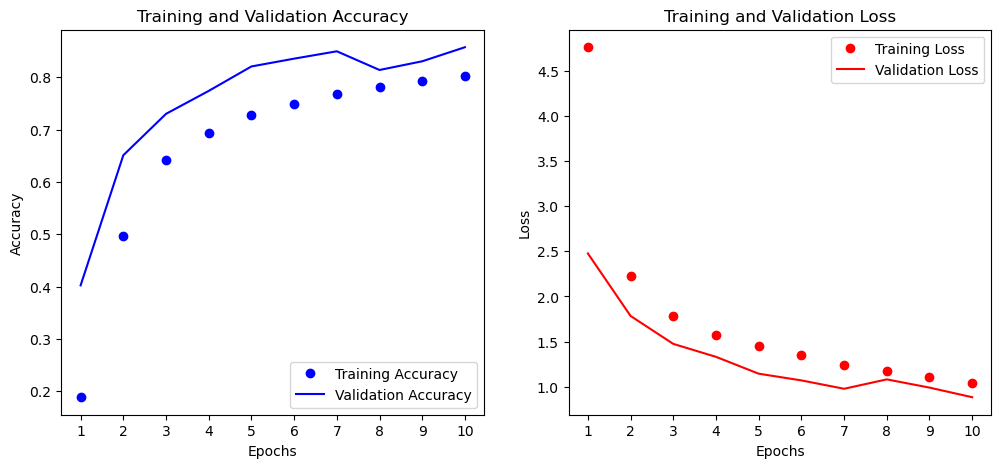

In [22]:
# Access the history dictionary
acc = history_deep_calibrated_da.history['accuracy']
val_acc = history_deep_calibrated_da.history['val_accuracy']
loss = history_deep_calibrated_da.history['loss']
val_loss = history_deep_calibrated_da.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()